## 데이콘 Basic 스트레스 지수 예측 : 건강 데이터로 마음의 균형을 찾아라!

주제: 스트레스 점수 예측 AI 알고리즘 개발   
목표: 신체 데이터를 기반으로 스트레스 점수를 예측하는 AI 알고리즘을 개발

평가산식: MAE
Public Score: 전체 테스트 데이터 중 사전 샘플링된 50%
Private Score: 전체 테스트 데이터 중 나머지 50%

Data 설명

(범주형)
- gender : 성별

(연속형)
- age : 연령
- height : 키(cm)
- weight : 몸무게(kg)
- cholesterol : 콜레스테롤 수치
- systolic_blood_pressure : 수축기 혈압
- diastolic_blood_pressure : 이완기 혈압
- glucose : 혈당 수치(mg/dL)
- bone_density : 골밀도(g/cm²)
- activity : 생활시 운동 강도
- smoke_status : 흡연 상태
- medical_history : 만성질환
- family_medical_history : 가족력
- sleep_pattern : 수면패턴
- edu_level : 학력
- mean_working : 1주일당 평균 근로 시간
- stress_score : (TARGET) 스트레스 점수 

#### **Library Import**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, mean_absolute_error


# 한글 폰트 설정
font_path = "/System/Library/Fonts/Supplemental/AppleGothic.ttf"  # Mac 기본 한글 폰트 경로
font_prop = font_manager.FontProperties(fname=font_path)

---

#### **Load Data**

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

print(train.shape, test.shape, submission.shape)

(3000, 18) (3000, 17) (3000, 2)


---

#### **EDA**

In [3]:
train.head(5)

,ID,gender,age,height,weight,cholesterol,systolic_blood_pressure,diastolic_blood_pressure,glucose,bone_density,activity,smoke_status,medical_history,family_medical_history,sleep_pattern,edu_level,mean_working,stress_score
0,TRAIN_0000,F,72,161.49,58.47,279.84,165,100,143.35,0.87,moderate,ex-smoker,high blood pressure,diabetes,sleep difficulty,bachelors degree,NaN,0.63
1,TRAIN_0001,M,88,179.87,77.60,257.37,178,111,146.94,0.07,moderate,ex-smoker,NaN,diabetes,normal,graduate degree,NaN,0.83
2,TRAIN_0002,M,47,182.47,89.93,226.66,134,95,142.61,1.18,light,ex-smoker,NaN,NaN,normal,high school diploma,9.0,0.70
3,TRAIN_0003,M,69,185.78,68.63,206.74,158,92,137.26,0.48,intense,ex-smoker,high blood pressure,NaN,oversleeping,graduate degree,NaN,0.17
4,TRAIN_0004,F,81,164.63,71.53,255.92,171,116,129.37,0.34,moderate,ex-smoker,diabetes,diabetes,sleep difficulty,bachelors degree,NaN,0.36


📊 변수별 결측률 (%)
family_medical_history      49.533333
medical_history             42.966667
mean_working                34.400000
edu_level                   20.233333
ID                           0.000000
gender                       0.000000
sleep_pattern                0.000000
smoke_status                 0.000000
activity                     0.000000
bone_density                 0.000000
glucose                      0.000000
diastolic_blood_pressure     0.000000
systolic_blood_pressure      0.000000
cholesterol                  0.000000
weight                       0.000000
height                       0.000000
age                          0.000000
stress_score                 0.000000
dtype: float64


/var/folders/0p/p1yx5lj17yx384d74tkfr6480000gn/T/ipykernel_84089/3040109459.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train[col], palette="pastel", ax=axes[i])
/var/folders/0p/p1yx5lj17yx384d74tkfr6480000gn/T/ipykernel_84089/3040109459.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train[col], palette="pastel", ax=axes[i])
/var/folders/0p/p1yx5lj17yx384d74tkfr6480000gn/T/ipykernel_84089/3040109459.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train[col], palette="pastel", ax=axes[i])
/var/folders/0p/p1yx5l

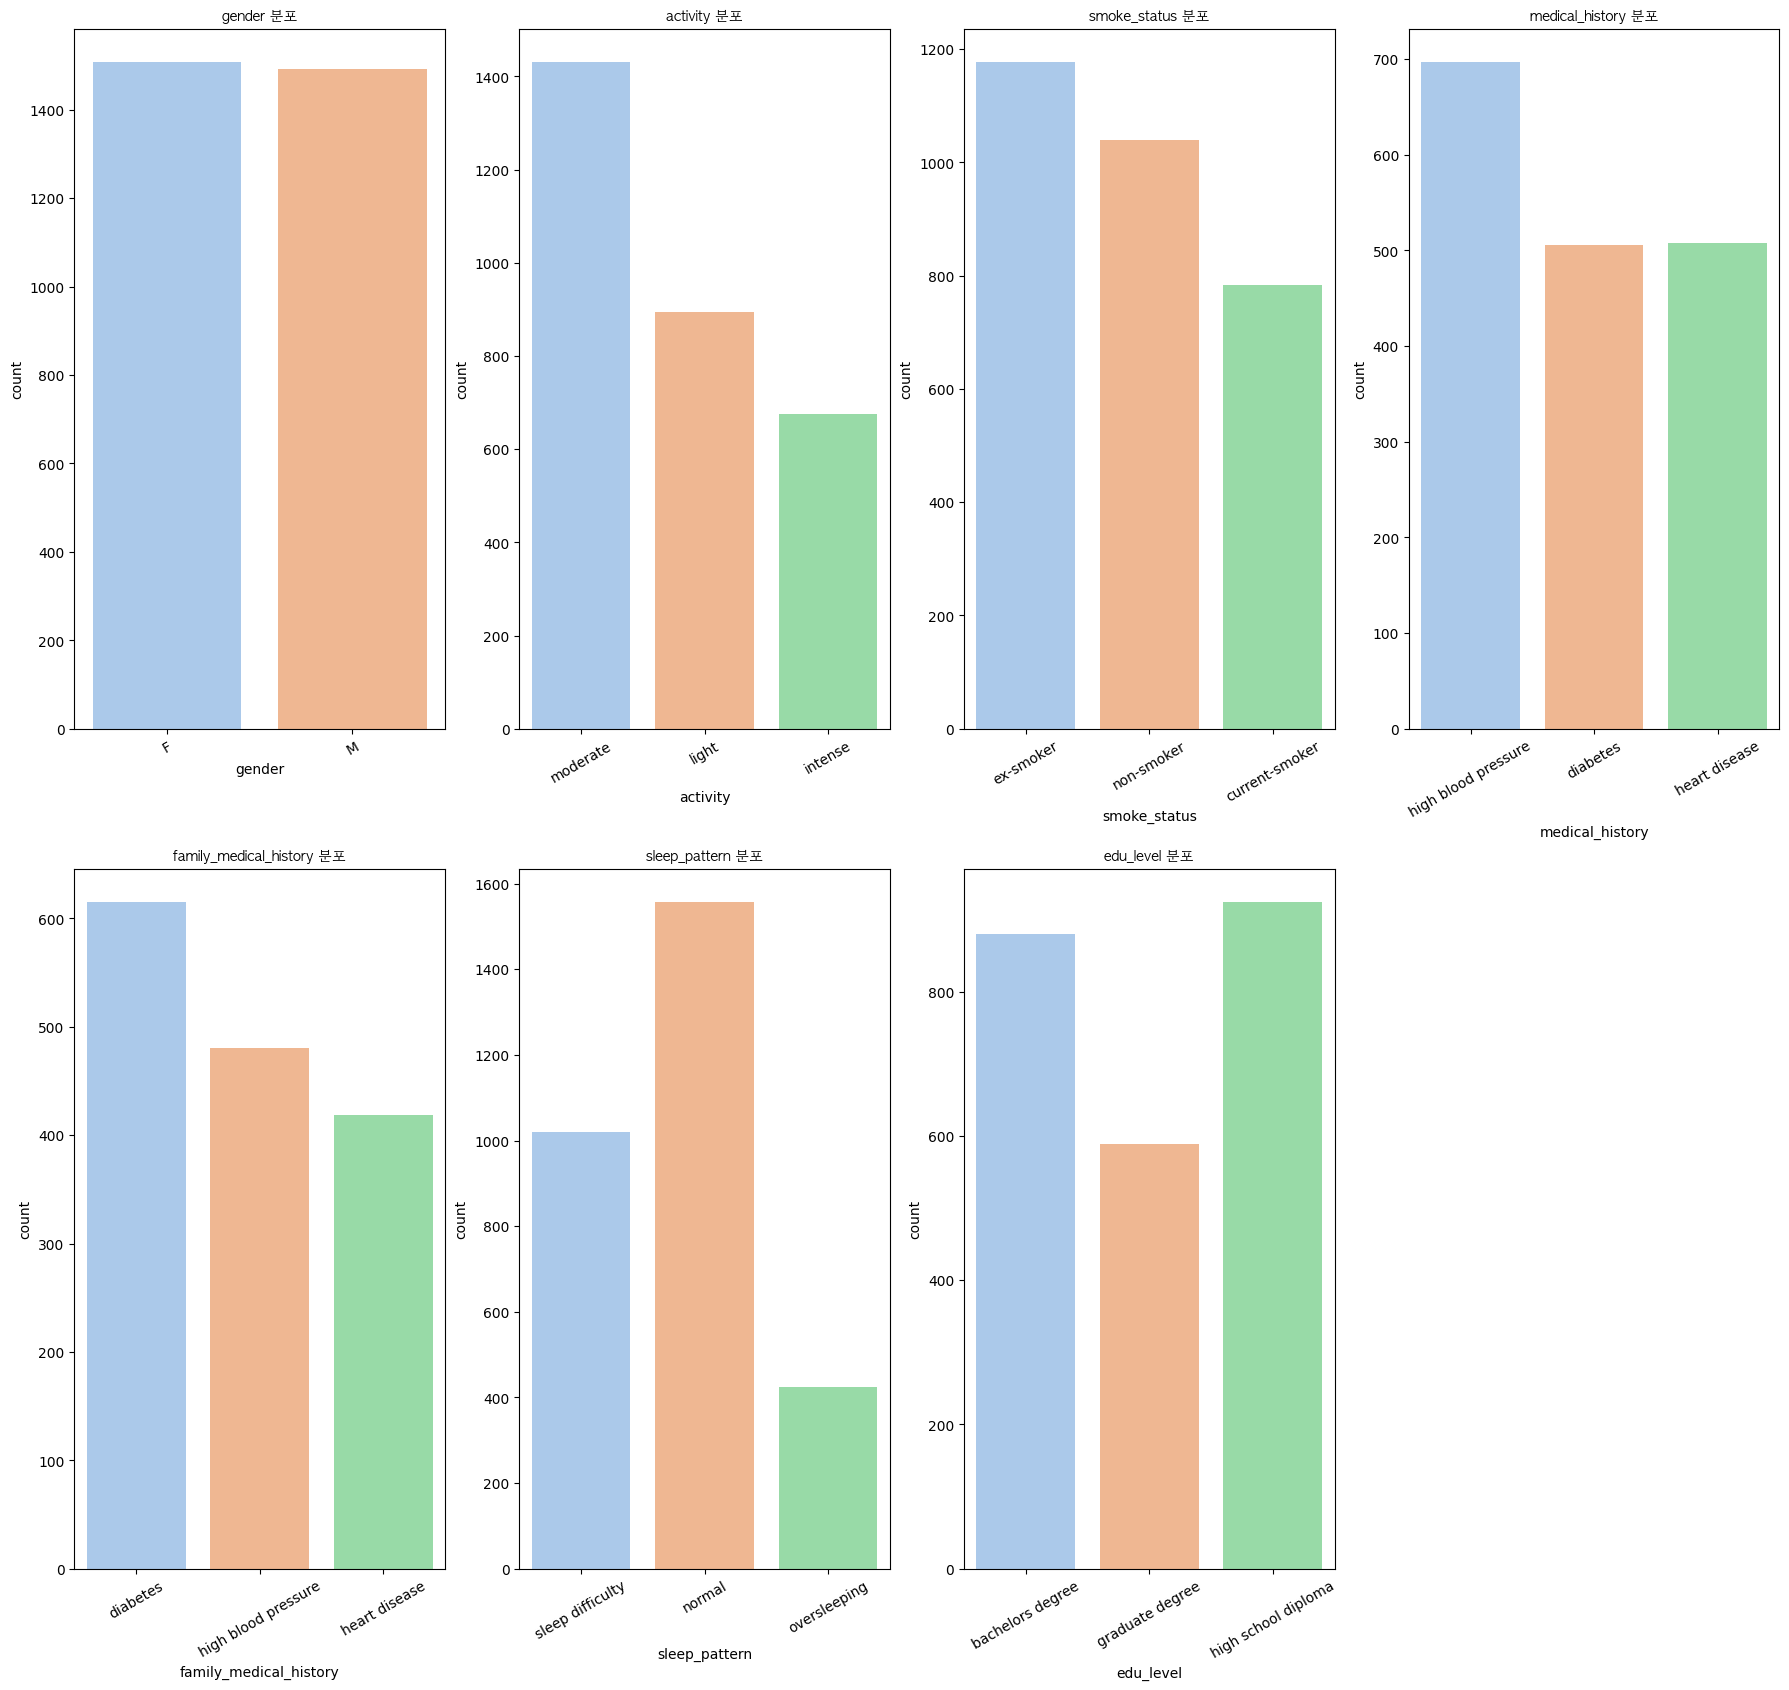

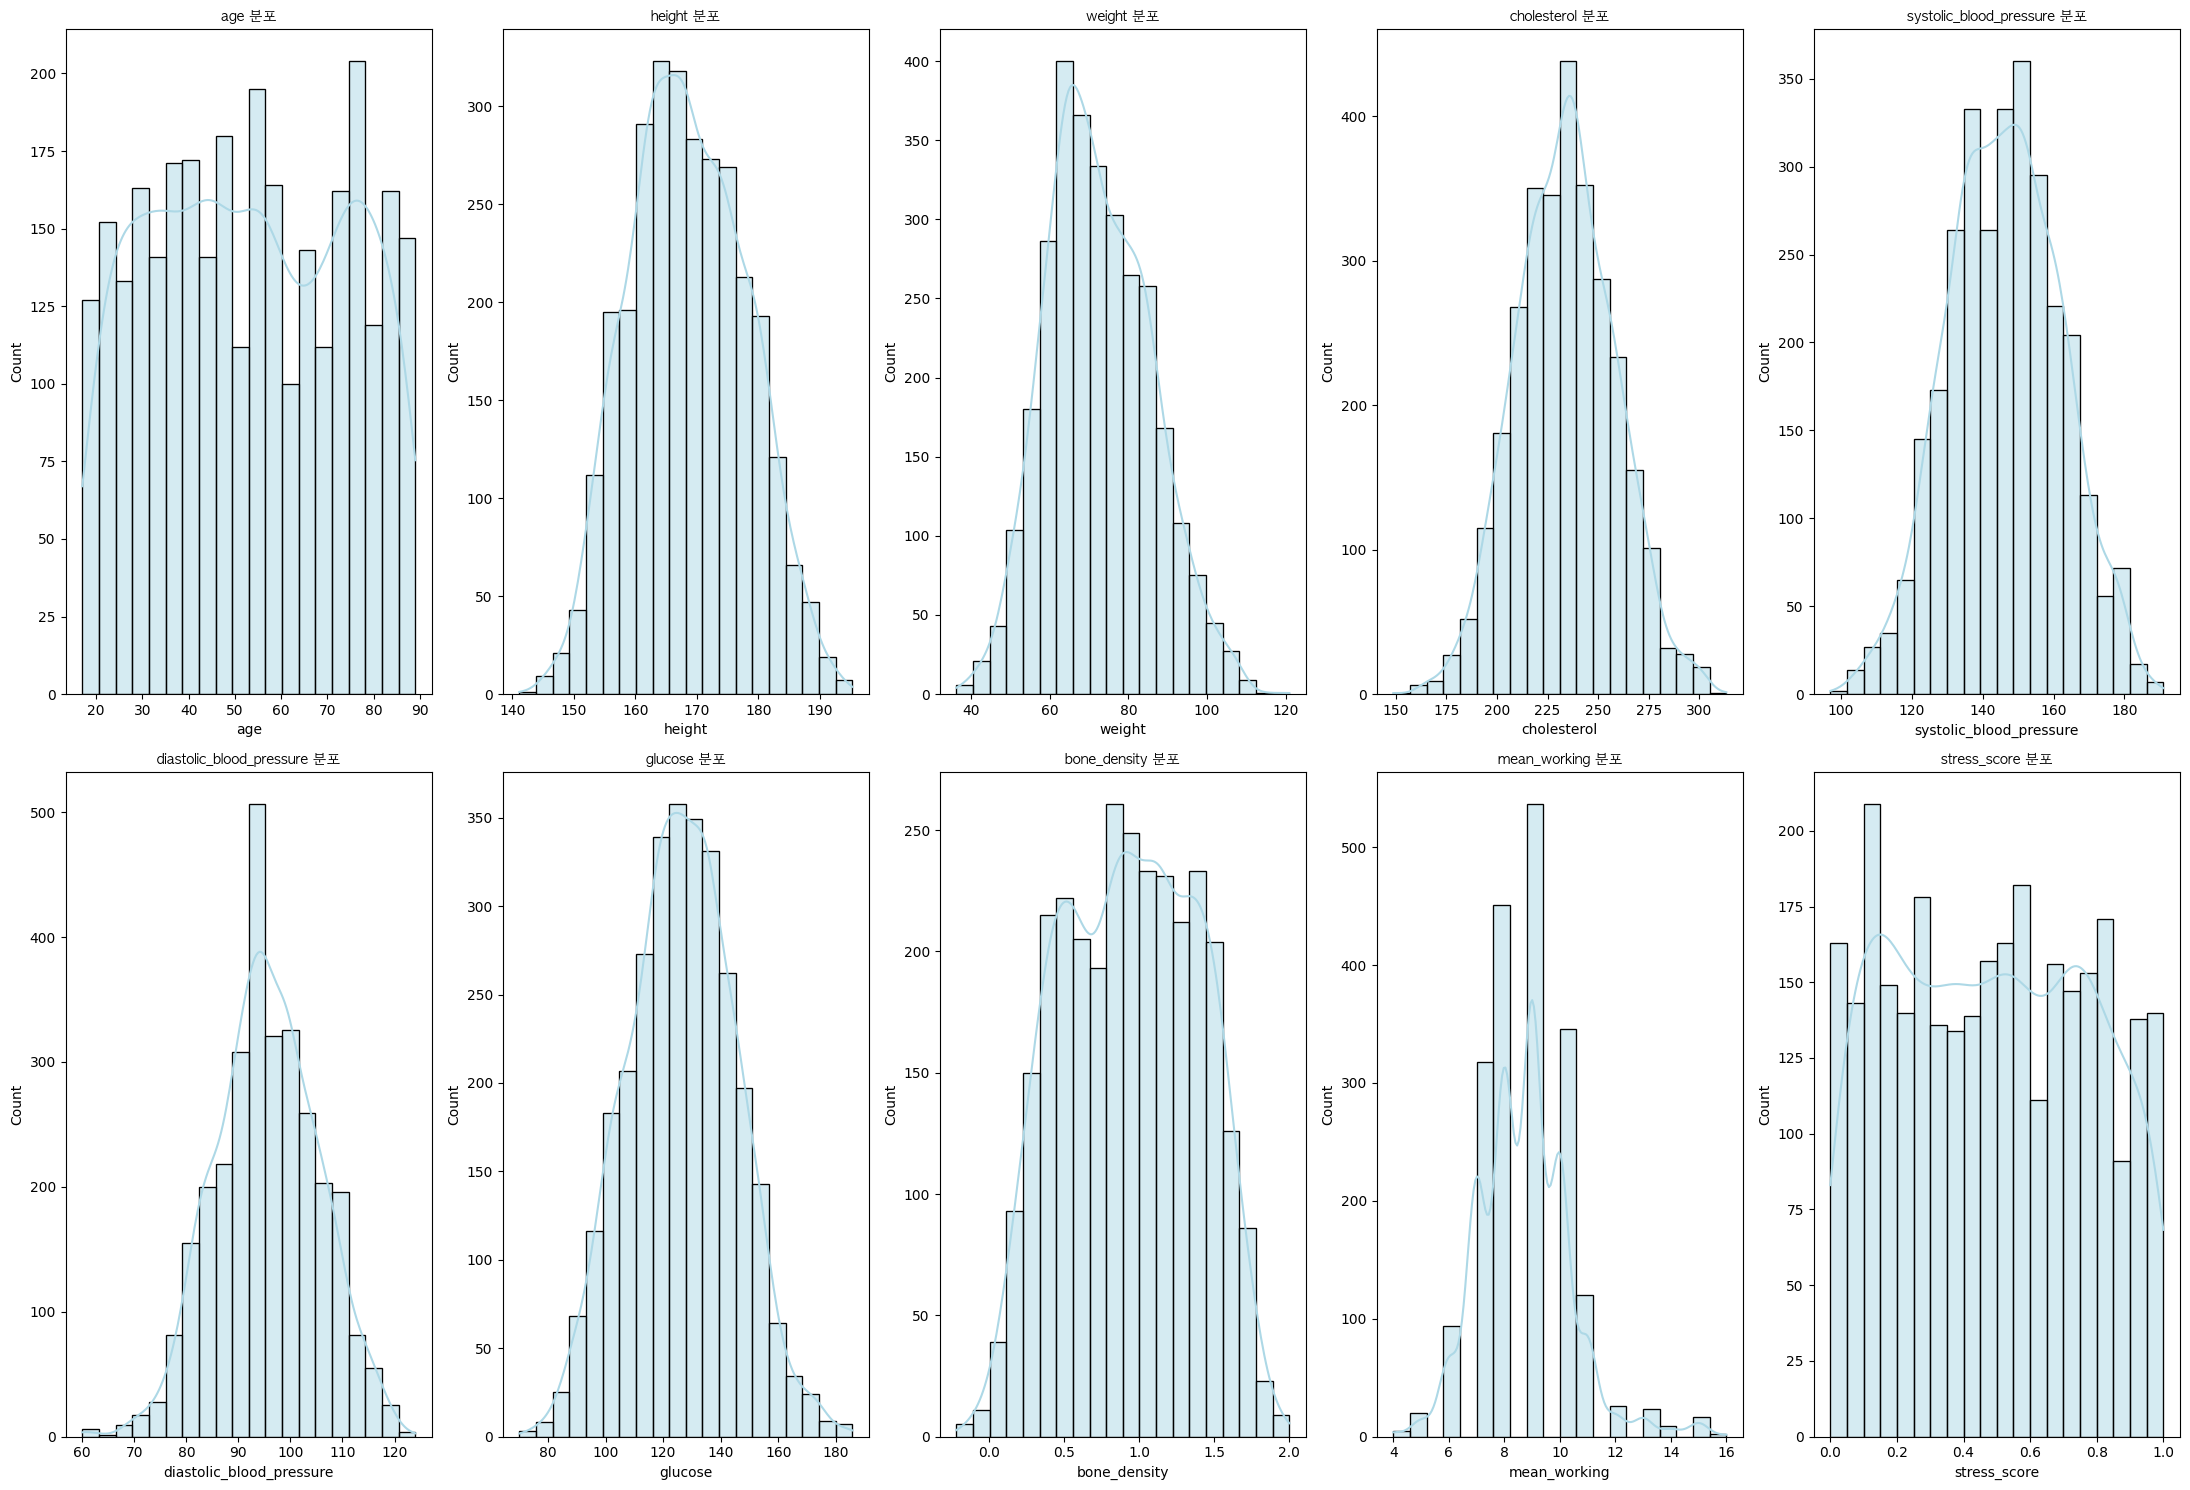

In [4]:
# 결측률 확인
missing_rate = train.isnull().mean() * 100
print("📊 변수별 결측률 (%)")
print(missing_rate.sort_values(ascending=False))

# 변수별 분포 자동화
categorical_cols = ["gender", "activity", "smoke_status", 
                    "medical_history", "family_medical_history", 
                    "sleep_pattern", "edu_level"]

numerical_cols = ["age", "height", "weight", "cholesterol",
                  "systolic_blood_pressure", "diastolic_blood_pressure",
                  "glucose", "bone_density", "mean_working", "stress_score"]

# 범주형 분포 subplot (2x4)
fig, axes = plt.subplots(2, 4, figsize=(22, 20))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.countplot(x=train[col], palette="pastel", ax=axes[i])
    axes[i].set_title(f"{col} 분포", fontproperties=font_prop)
    axes[i].tick_params(axis='x', rotation=30)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# 수치형 분포 subplot (2x5)
fig, axes = plt.subplots(2, 5, figsize=(22, 15))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.histplot(train[col], kde=True, bins=20, color="lightblue", ax=axes[i])
    axes[i].set_title(f"{col} 분포", fontproperties=font_prop)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**heatmap**

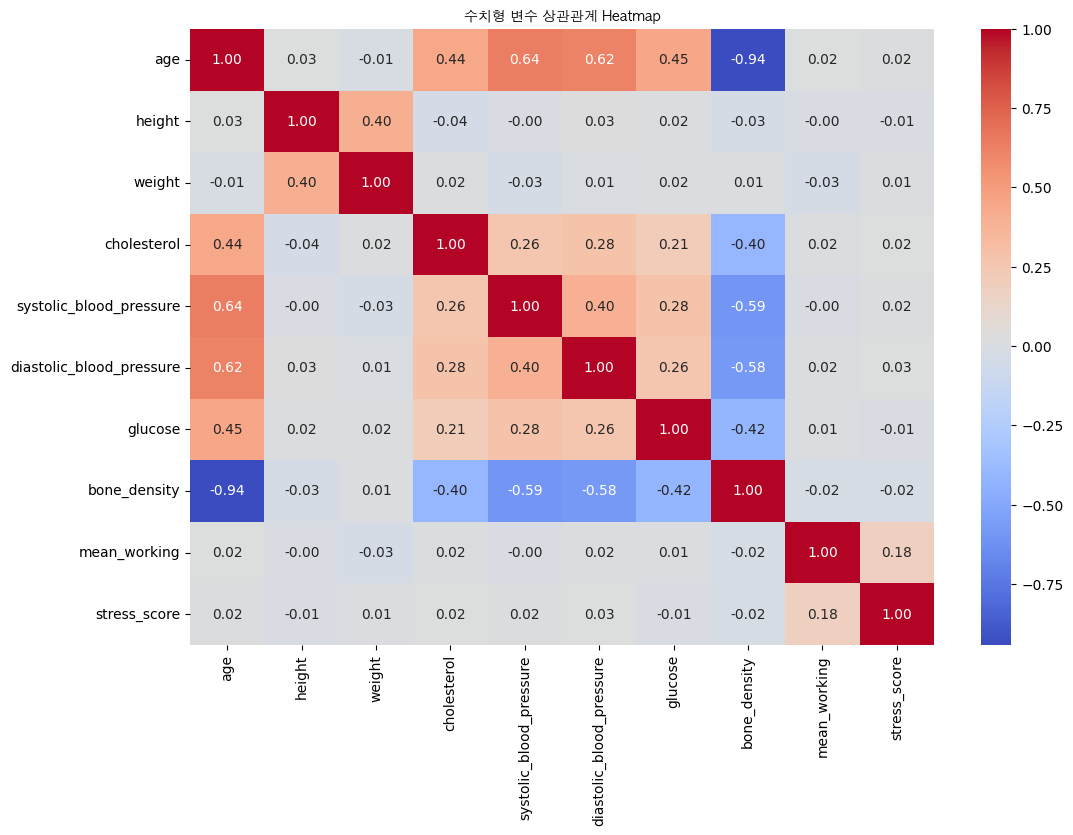

In [5]:
# 연속형 변수만 선택
num_cols = ["age", "height", "weight", "cholesterol",
                  "systolic_blood_pressure", "diastolic_blood_pressure",
                  "glucose", "bone_density", "mean_working", "stress_score"]

# 상관계수 계산
corr = train[num_cols].corr()

# 히트맵 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("수치형 변수 상관관계 Heatmap", fontproperties=font_prop)
plt.show()

stress_score와 가장 연관이 있는 변수는 아직까지 확인할 수 없다. (결측치 처리 후 다시 히트맵 확인 예정)

**Box Plot**

/var/folders/0p/p1yx5lj17yx384d74tkfr6480000gn/T/ipykernel_84089/2951713911.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y="stress_score", data=train, ax=axes[i], palette="Set3")
/var/folders/0p/p1yx5lj17yx384d74tkfr6480000gn/T/ipykernel_84089/2951713911.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y="stress_score", data=train, ax=axes[i], palette="Set3")
/var/folders/0p/p1yx5lj17yx384d74tkfr6480000gn/T/ipykernel_84089/2951713911.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y="stress_score", data=

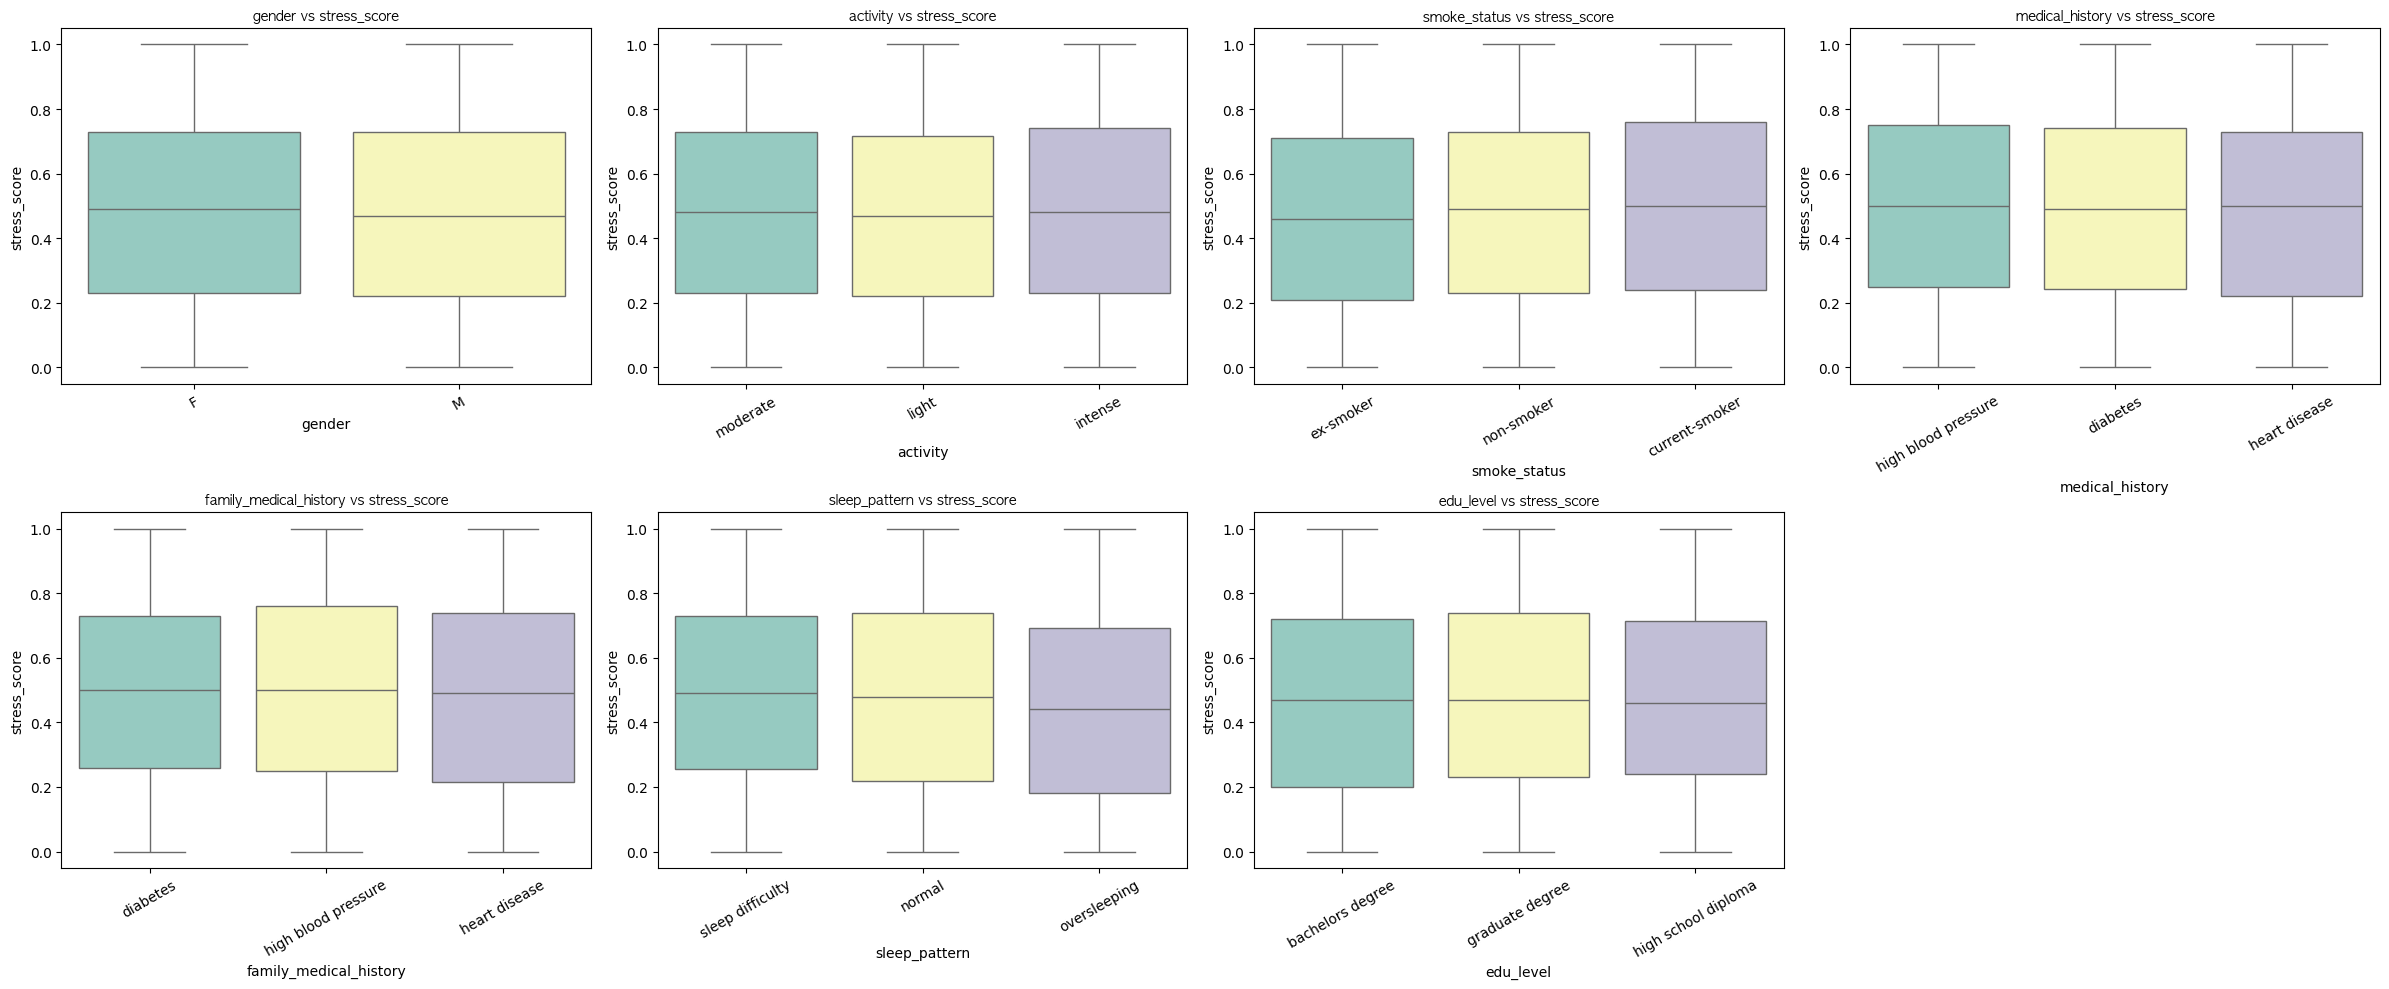

In [6]:
categorical_cols = [
    "gender", "activity", "smoke_status", 
    "medical_history", "family_medical_history", 
    "sleep_pattern", "edu_level"
]

# 2x4 그리드로 시각화
fig, axes = plt.subplots(2, 4, figsize=(24, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.boxplot(x=col, y="stress_score", data=train, ax=axes[i], palette="Set3")
    axes[i].set_title(f"{col} vs stress_score", fontproperties=font_prop)
    axes[i].tick_params(axis='x', rotation=30)

# 남는 subplot 제거
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

stress_score와 가장 연관이 있는 건 **mean_working, sleep_pattern, edu_level** 이다.

* 추가 고려해 볼 파생변수
1. BMI: weight/(height)^2
2. 평균혈압 (MAP): (2 x diastolic + systolic) / 3
3. 나이 대비 골밀도 지표 (Age-BoneDensity Index)

---

#### **Data Preprocessing**

**결측치가 있는 데이터**

1. medical_history: 
- high blood pressure: 고혈압
- diabetes: 당뇨
- heart disease: 심장병

=> 결측치 처리: no histroy 추가
=> 결측 자체가 중요한 정보일 수 있기 때문에 medical_history_missing 컬럼 추가

2. family_medical_history:
- high blood pressure: 고혈압
- diabetes: 당뇨
- heart disease: 심장병

=> 결측치 처리: no histroy 추가
=> 결측 자체가 중요한 정보일 수 있기 때문에 family_medical_history_missing 컬럼 추가

3. edu_level:
- bachelors degree: 대학교 졸업
- graduate degree: 대학원 학위
- high school diploma: 고등학교 졸업

=> Ierative Imputer (MICE, 다중대체법) 사용
=> 결측 변수를 다른 변수들로 예측하는 회귀모델을 반복 돌려서 보정

4. mean_working:
- min: 4
- max: 16

=> KNN Imputer로 결측값이 있는 변수를 비슷한 특성을 가진 K개의 이웃 데이터 평균으로 채움

**1. medical_history & family_medical_history**

In [7]:
for col in ["medical_history", "family_medical_history"]:
    # 플래그 추가
    train[col + "_missing"] = train[col].isnull().astype(int)
    test[col + "_missing"] = test[col].isnull().astype(int)
    
    # 결측치 → no_history
    train[col] = train[col].fillna("no_history")
    test[col] = test[col].fillna("no_history")

print(train["medical_history"].value_counts(dropna=False))
print(train["medical_history_missing"].value_counts())
print('--------------------------------')
print(test["medical_history"].value_counts(dropna=False))
print(test["medical_history_missing"].value_counts())
print('--------------------------------')
print(train["family_medical_history"].value_counts(dropna=False))
print(train["family_medical_history_missing"].value_counts())
print('--------------------------------')
print(test["family_medical_history"].value_counts(dropna=False))
print(test["family_medical_history_missing"].value_counts())

no_history             1289
high blood pressure     697
heart disease           508
diabetes                506
Name: medical_history, dtype: int64
0    1711
1    1289
Name: medical_history_missing, dtype: int64
--------------------------------
no_history             1309
high blood pressure     655
diabetes                558
heart disease           478
Name: medical_history, dtype: int64
0    1691
1    1309
Name: medical_history_missing, dtype: int64
--------------------------------
no_history             1486
diabetes                615
high blood pressure     480
heart disease           419
Name: family_medical_history, dtype: int64
0    1514
1    1486
Name: family_medical_history_missing, dtype: int64
--------------------------------
no_history             1416
diabetes                675
heart disease           487
high blood pressure     422
Name: family_medical_history, dtype: int64
0    1584
1    1416
Name: family_medical_history_missing, dtype: int64


**2. edu_level**

In [8]:
# Label Encoding for edu_level, sleep_pattern (숫자로 바꿔야 Imputer 가능)
le_edu = LabelEncoder()
le_sleep = LabelEncoder()

train["edu_level_encoded"] = train["edu_level"].map(lambda x: le_edu.fit(train["edu_level"].dropna()).transform([x])[0] if pd.notnull(x) else np.nan)
train["sleep_pattern_encoded"] = le_sleep.fit_transform(train["sleep_pattern"])

test["edu_level_encoded"] = test["edu_level"].map(lambda x: le_edu.transform([x])[0] if pd.notnull(x) else np.nan)
test["sleep_pattern_encoded"] = le_sleep.transform(test["sleep_pattern"])

# Iterative Imputer train에 fit
imp = IterativeImputer(random_state=42, max_iter=10)
train_imputed = imp.fit_transform(train[["edu_level_encoded", "age", "mean_working", "sleep_pattern_encoded"]])
test_imputed = imp.transform(test[["edu_level_encoded", "age", "mean_working", "sleep_pattern_encoded"]])

train["edu_level_encoded"] = np.round(train_imputed[:,0]).astype(int)
test["edu_level_encoded"] = np.round(test_imputed[:,0]).astype(int)

train["edu_level"] = le_edu.inverse_transform(train["edu_level_encoded"])
test["edu_level"] = le_edu.inverse_transform(test["edu_level_encoded"])

print(train["edu_level"].value_counts())
print('--------------------------------')
print(test["edu_level"].value_counts())

graduate degree        1196
high school diploma     924
bachelors degree        880
Name: edu_level, dtype: int64
--------------------------------
graduate degree        1270
bachelors degree        888
high school diploma     842
Name: edu_level, dtype: int64


**3. mean_working**

In [9]:
# Label Encoding (다시 재사용)
train["edu_level_encoded"] = le_edu.transform(train["edu_level"])
test["edu_level_encoded"] = le_edu.transform(test["edu_level"])

train["sleep_pattern_encoded"] = le_sleep.transform(train["sleep_pattern"])
test["sleep_pattern_encoded"] = le_sleep.transform(test["sleep_pattern"])

# KNN Imputer
knn_features = ["mean_working", "age", "edu_level_encoded", "sleep_pattern_encoded"]

imputer = KNNImputer(n_neighbors=5)
train[knn_features] = imputer.fit_transform(train[knn_features])
test[knn_features] = imputer.transform(test[knn_features])

train["mean_working"] = train["mean_working"].round(1)
test["mean_working"] = test["mean_working"].round(1)

print(train["mean_working"].describe())
print('--------------------------------')
print(test["mean_working"].describe())

count    3000.000000
mean        8.693867
std         1.344631
min         4.000000
25%         8.000000
50%         8.800000
75%         9.000000
max        16.000000
Name: mean_working, dtype: float64
--------------------------------
count    3000.000000
mean        8.778800
std         1.349419
min         4.000000
25%         8.000000
50%         8.800000
75%         9.000000
max        16.000000
Name: mean_working, dtype: float64


**범주형 변수 인코딩**

In [10]:
categorical_cols = ["gender", "activity", "smoke_status", 
                    "medical_history", "family_medical_history", 
                    "sleep_pattern", "edu_level"]

label_encoders = {}
for col in categorical_cols:
    combined = pd.concat([train[col], test[col]], axis=0).astype(str)  # 문자열 통일
    le = LabelEncoder()
    le.fit(combined)

    train[col] = le.transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str))

    label_encoders[col] = le

    # ✅ 변환 결과 출력
    print(f"\n[{col}]")
    print("classes:", le.classes_)
    print("train sample:", train[col].unique()[:10])
    print("test sample:", test[col].unique()[:10])


[gender]
classes: ['F' 'M']
train sample: [0 1]
test sample: [0 1]

[activity]
classes: ['intense' 'light' 'moderate']
train sample: [2 1 0]
test sample: [2 0 1]

[smoke_status]
classes: ['current-smoker' 'ex-smoker' 'non-smoker']
train sample: [1 2 0]
test sample: [0 1 2]

[medical_history]
classes: ['diabetes' 'heart disease' 'high blood pressure' 'no_history']
train sample: [2 3 0 1]
test sample: [2 3 0 1]

[family_medical_history]
classes: ['diabetes' 'heart disease' 'high blood pressure' 'no_history']
train sample: [0 3 2 1]
test sample: [1 3 0 2]

[sleep_pattern]
classes: ['normal' 'oversleeping' 'sleep difficulty']
train sample: [2 0 1]
test sample: [1 0 2]

[edu_level]
classes: ['bachelors degree' 'graduate degree' 'high school diploma']
train sample: [0 1 2]
test sample: [1 0 2]


**파생변수 생성**

1. BMI
- 저체중, 정상체중, 과체중, 비만을 구분하여 체형과 건강상태, 나아가 스트레스 수준에도 영향을 줄 수 있다고 판단

2. MAP
- 고혈압 여부를 판단하여, 혈압이 높으면 스트레스 및 심혈관 질환 위험 증가와 연관 가능

3. 나이 대비 골밀도
- 골밀도는 건강 및 체력과 밀접한 관련이 있기 때문에 장기적 스트레스 및 생활습관에 영향을 받을 수 있음
- 값의 범위가 크기 때문에 로그 변환 예정

In [11]:
# BMI (체질량 지수)
train["BMI"] = train["weight"] / (train["height"] / 100) ** 2
test["BMI"] = test["weight"] / (test["height"] / 100) ** 2

# 로그 변환
train["BMI"] = np.log1p(train["BMI"])
test["BMI"] = np.log1p(test["BMI"])

# MAP (평균혈압)
train["MAP"] = (2 * train["diastolic_blood_pressure"] + train["systolic_blood_pressure"]) / 3
test["MAP"] = (2 * test["diastolic_blood_pressure"] + test["systolic_blood_pressure"]) / 3

# Age-BoneDensity Index (나이 대비 골밀도 지표)
train["Age_BoneDensity_Index"] = train["age"] / train["bone_density"]
test["Age_BoneDensity_Index"] = test["age"] / test["bone_density"]

# 로그 변환
train["Age_BoneDensity_Index"] = np.log1p(train["Age_BoneDensity_Index"])
test["Age_BoneDensity_Index"] = np.log1p(test["Age_BoneDensity_Index"])

# 결과 확인
print(train[["BMI", "MAP", "Age_BoneDensity_Index"]].head())
print(test[["BMI", "MAP", "Age_BoneDensity_Index"]].head())

        BMI         MAP  Age_BoneDensity_Index
0  3.153604  121.666667               4.427939
1  3.218286  133.333333               7.137392
2  3.332555  108.000000               3.709430
3  3.039010  114.000000               4.975008
4  3.310246  134.333333               5.477448
        BMI         MAP  Age_BoneDensity_Index
0  3.421320  120.333333               4.957069
1  3.269198  117.333333               5.110214
2  3.384041  109.333333               3.709246
3  3.367986  114.000000               4.723295
4  3.304003  100.666667               3.244461


/opt/miniconda3/envs/0630/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


**추가 파생변수**

결과 제출 후 전처리 보완을 위해 추가 파생변수 생성

1. Pulse Pressure
- 혈압차이는 심혈관계 스트레스 지표로 자주 쓰이기 때문에 추가

2. BMI X 활동량
- 비만인데 활동량이 적으면 스트레스가 더 클 가능성이 있음

3. 수면 패턴 X 근로시간
- 야근 + 수면 부족 -> 스트레스 상승

In [12]:
# Pulse Pressure (수축기 - 이완기 혈압)
train["Pulse_Pressure"] = train["systolic_blood_pressure"] - train["diastolic_blood_pressure"]
test["Pulse_Pressure"] = test["systolic_blood_pressure"] - test["diastolic_blood_pressure"]

# Activity_Adjusted_BMI (활동량 보정 BMI)
train["Activity_BMI"] = train["BMI"] * train["activity"]
test["Activity_BMI"] = test["BMI"] * test["activity"]

# Sleep_Work (수면패턴 × 근로시간 상호작용)
train["Sleep_Work"] = train["sleep_pattern"] * train["mean_working"]
test["Sleep_Work"] = test["sleep_pattern"] * test["mean_working"]

print(train[["Pulse_Pressure", "Activity_BMI", "Sleep_Work"]].head())

   Pulse_Pressure  Activity_BMI  Sleep_Work
0              65      6.307208        18.0
1              67      6.436571         0.0
2              39      3.332555         0.0
3              66      0.000000         8.4
4              55      6.620493        18.0


**구간화**

In [13]:
# 1. 연속형 변수 구간화 (binning)
# Age (연령대)
bins = [0, 19, 29, 39, 49, 59, 69, 200]
labels = ["10대이하", "20대", "30대", "40대", "50대", "60대", "70대이상"]
train["Age_bin"] = pd.cut(train["age"], bins=bins, labels=labels)
test["Age_bin"] = pd.cut(test["age"], bins=bins, labels=labels)

# BMI (체질량 구간, WHO 기준)
bins = [0, 18.5, 25, 30, 35, 100]
labels = ["저체중", "정상", "과체중", "비만", "고도비만"]
train["BMI_bin"] = pd.cut(train["BMI"], bins=bins, labels=labels)
test["BMI_bin"] = pd.cut(test["BMI"], bins=bins, labels=labels)

# MAP (혈압 단계, AHA 기준)
bins = [0, 120, 130, 140, 300]
labels = ["정상", "고혈압 전단계", "고혈압 1단계", "고혈압 2단계"]
train["MAP_bin"] = pd.cut(train["MAP"], bins=bins, labels=labels)
test["MAP_bin"] = pd.cut(test["MAP"], bins=bins, labels=labels)

# Cholesterol (콜레스테롤 구간)
bins = [0, 200, 240, 1000]
labels = ["정상", "경계", "높음"]
train["Cholesterol_bin"] = pd.cut(train["cholesterol"], bins=bins, labels=labels)
test["Cholesterol_bin"] = pd.cut(test["cholesterol"], bins=bins, labels=labels)

# Glucose (혈당 구간)
bins = [0, 100, 126, 1000]
labels = ["정상", "당뇨 전단계", "당뇨"]
train["Glucose_bin"] = pd.cut(train["glucose"], bins=bins, labels=labels)
test["Glucose_bin"] = pd.cut(test["glucose"], bins=bins, labels=labels)

print(train[["Age_bin", "BMI_bin", "MAP_bin", "Cholesterol_bin", "Glucose_bin"]].head())

  Age_bin BMI_bin  MAP_bin Cholesterol_bin Glucose_bin
0   70대이상     저체중  고혈압 전단계              높음          당뇨
1   70대이상     저체중  고혈압 1단계              높음          당뇨
2     40대     저체중       정상              경계          당뇨
3     60대     저체중       정상              경계          당뇨
4   70대이상     저체중  고혈압 1단계              높음          당뇨


In [14]:
# 2. 범주형 변수 인코딩 (기존 + binning 포함)
categorical_cols = ["gender", "activity", "smoke_status", 
                    "medical_history", "family_medical_history", 
                    "sleep_pattern", "edu_level",
                    # binning 추가
                    "Age_bin", "BMI_bin", "MAP_bin", 
                    "Cholesterol_bin", "Glucose_bin"]

label_encoders = {}
for col in categorical_cols:
    combined = pd.concat([train[col], test[col]], axis=0).astype(str)
    le = LabelEncoder()
    le.fit(combined)

    train[col] = le.transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str))

    label_encoders[col] = le

    # 확인 출력
    print(f"\n[{col}] classes: {list(le.classes_)}")
    print("train sample:", train[col].unique()[:10])
    print("test sample:", test[col].unique()[:10])


[gender] classes: ['0', '1']
train sample: [0 1]
test sample: [0 1]

[activity] classes: ['0', '1', '2']
train sample: [2 1 0]
test sample: [2 0 1]

[smoke_status] classes: ['0', '1', '2']
train sample: [1 2 0]
test sample: [0 1 2]

[medical_history] classes: ['0', '1', '2', '3']
train sample: [2 3 0 1]
test sample: [2 3 0 1]

[family_medical_history] classes: ['0', '1', '2', '3']
train sample: [0 3 2 1]
test sample: [1 3 0 2]

[sleep_pattern] classes: ['0', '1', '2']
train sample: [2 0 1]
test sample: [1 0 2]

[edu_level] classes: ['0', '1', '2']
train sample: [0 1 2]
test sample: [1 0 2]

[Age_bin] classes: ['10대이하', '20대', '30대', '40대', '50대', '60대', '70대이상']
train sample: [6 3 5 0 2 4 1]
test sample: [6 3 4 2 5 1 0]

[BMI_bin] classes: ['저체중']
train sample: [0]
test sample: [0]

[MAP_bin] classes: ['고혈압 1단계', '고혈압 2단계', '고혈압 전단계', '정상']
train sample: [2 0 3]
test sample: [2 3 0 1]

[Cholesterol_bin] classes: ['경계', '높음', '정상']
train sample: [1 0 2]
test sample: [1 0 2]

[Glucose_b

**EDA: 그래프 재생성**

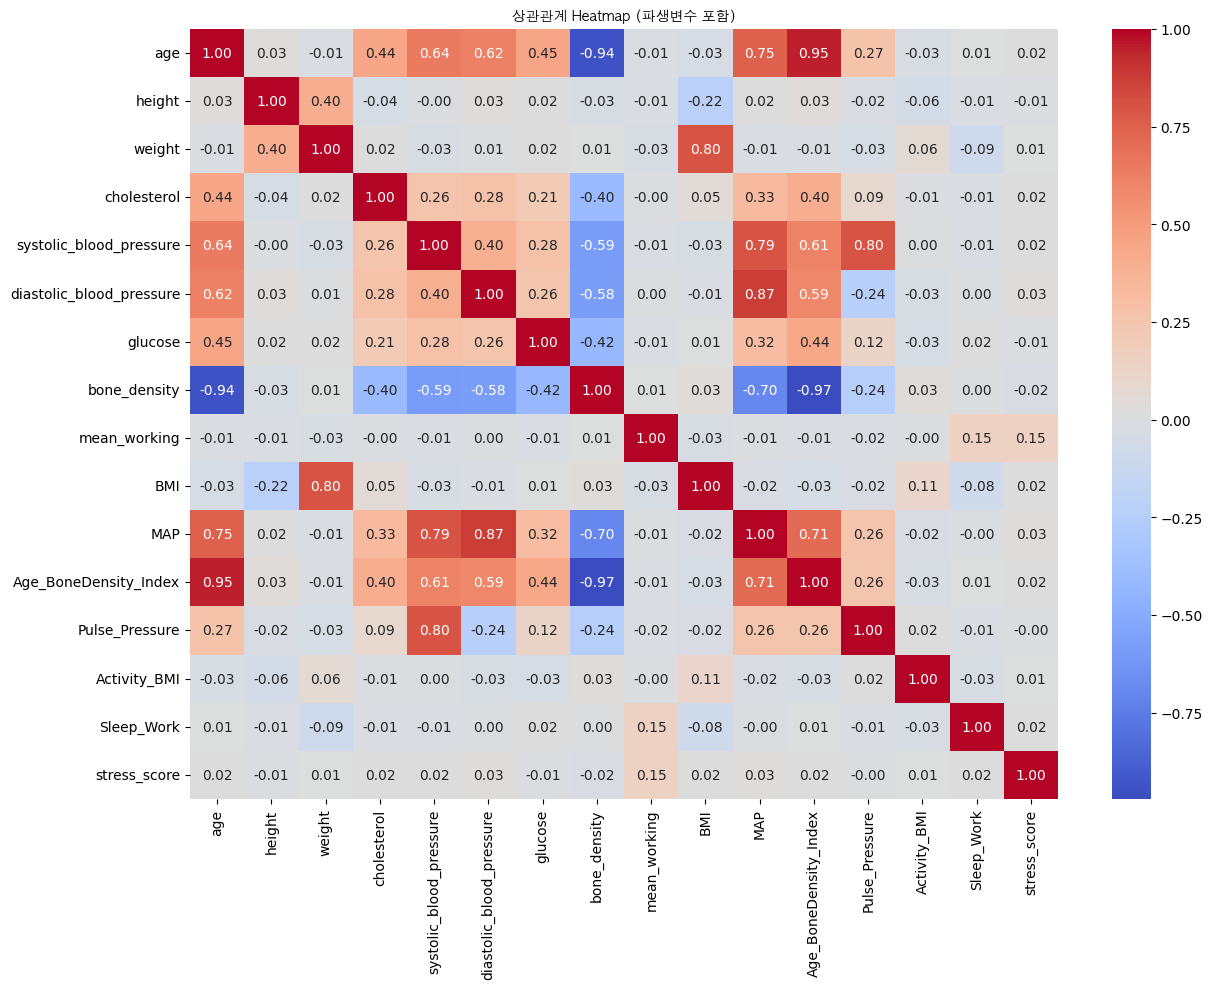

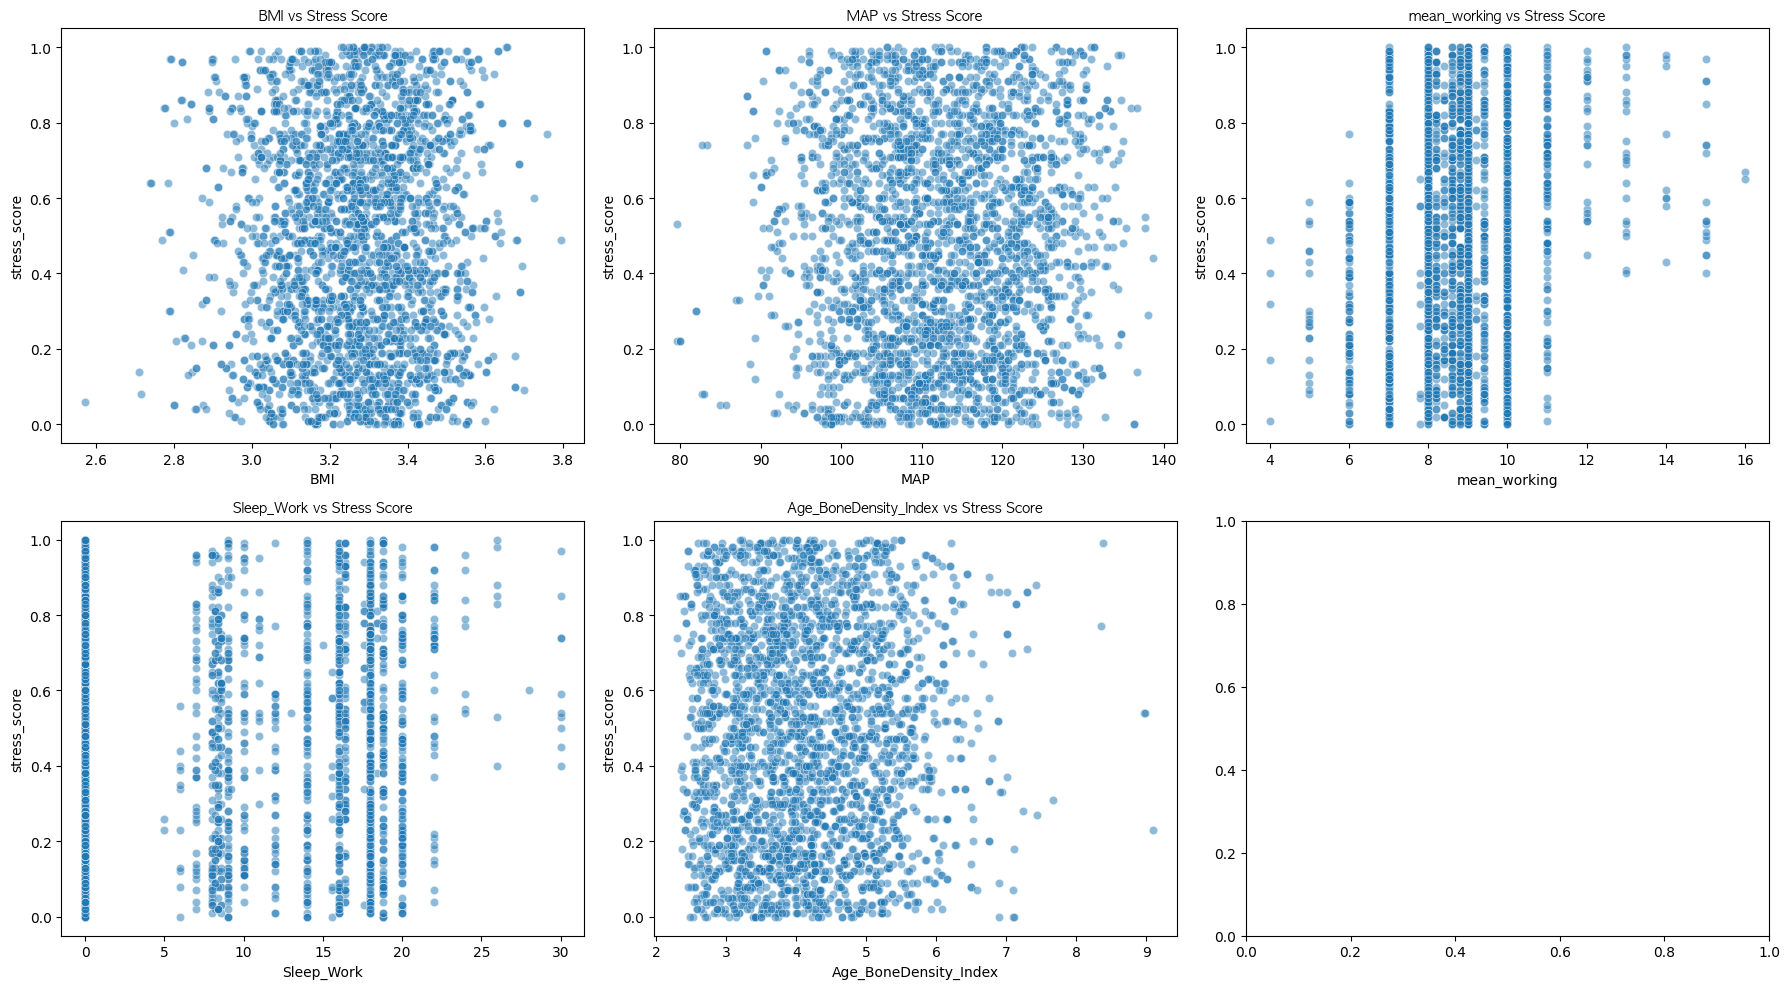

/var/folders/0p/p1yx5lj17yx384d74tkfr6480000gn/T/ipykernel_84089/117298550.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y="stress_score", data=train, ax=axes[i], palette="Set2")
/var/folders/0p/p1yx5lj17yx384d74tkfr6480000gn/T/ipykernel_84089/117298550.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y="stress_score", data=train, ax=axes[i], palette="Set2")
/var/folders/0p/p1yx5lj17yx384d74tkfr6480000gn/T/ipykernel_84089/117298550.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y="stress_score", data=tra

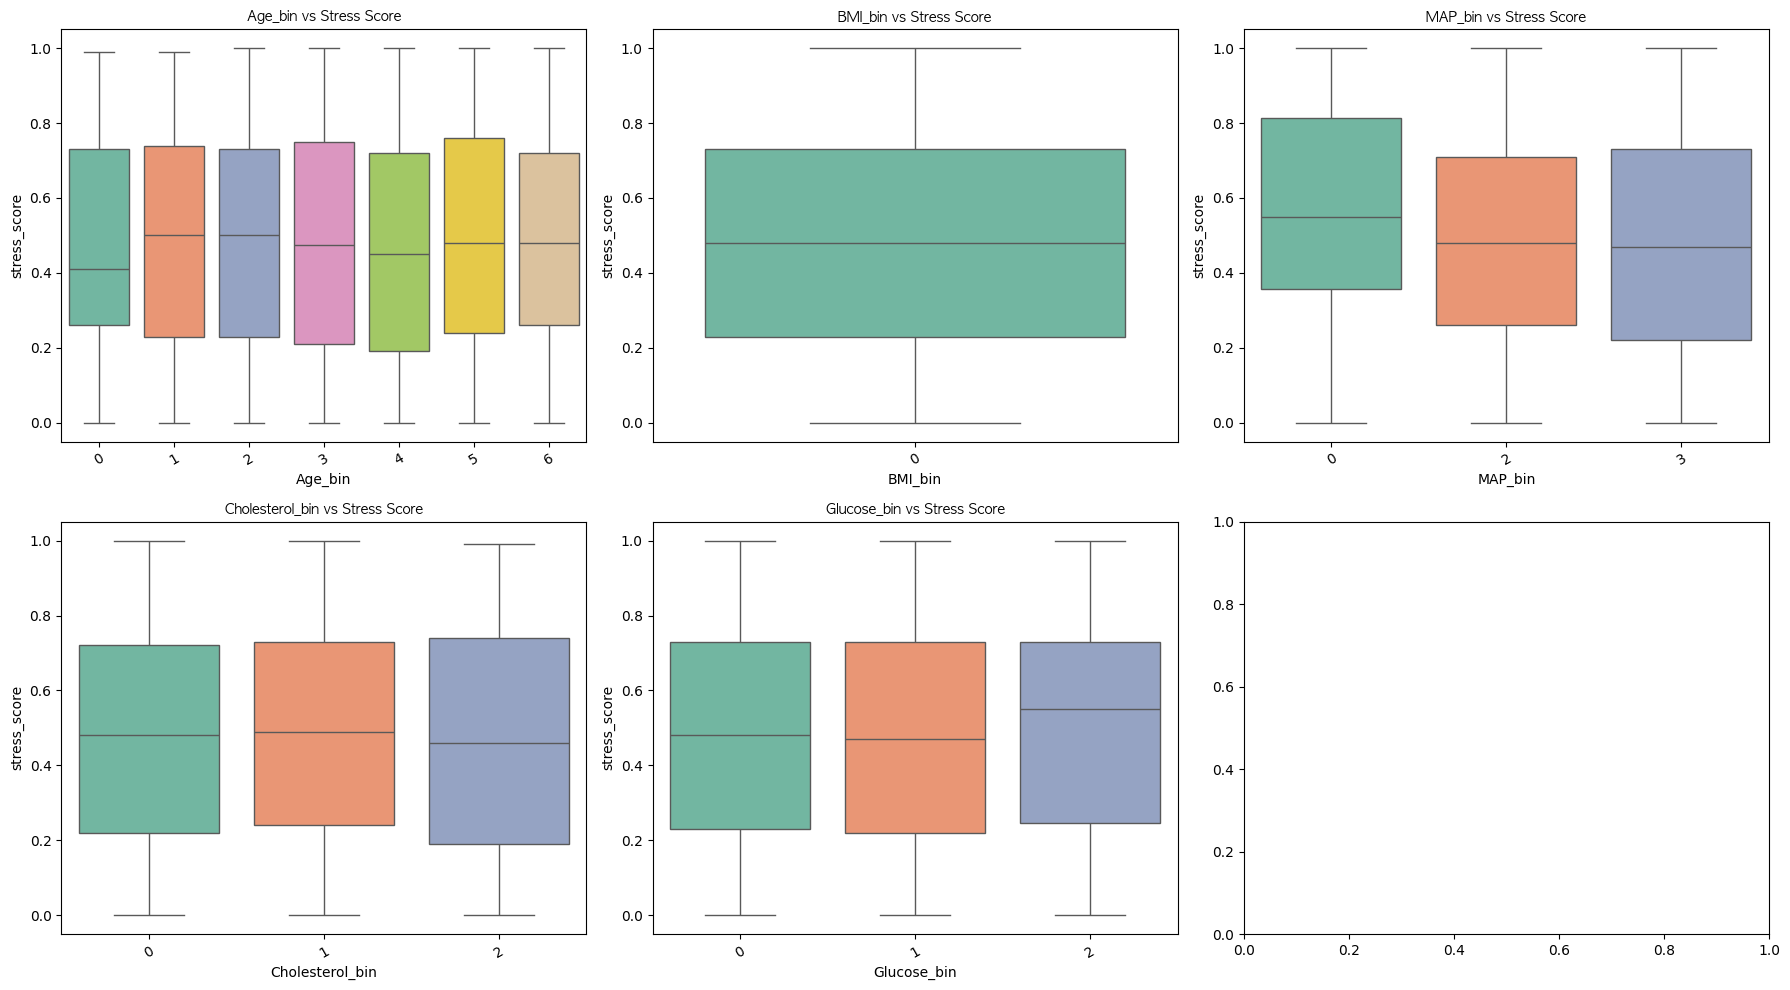

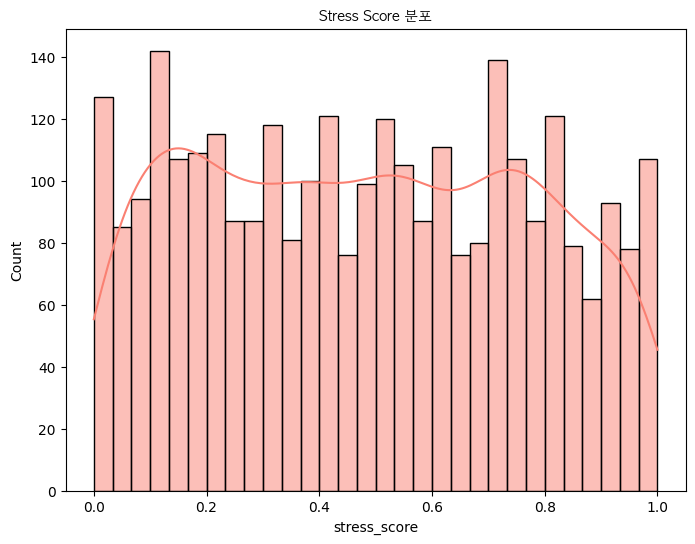

In [15]:
# 1. 히트맵
num_cols = ["age", "height", "weight", "cholesterol",
            "systolic_blood_pressure", "diastolic_blood_pressure",
            "glucose", "bone_density", "mean_working", 
            "BMI", "MAP", "Age_BoneDensity_Index", 
            "Pulse_Pressure", "Activity_BMI", "Sleep_Work",
            "stress_score"]

corr = train[num_cols].corr()
plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("상관관계 Heatmap (파생변수 포함)", fontproperties=font_prop)
plt.show()


# 2. 산점도
key_features = ["BMI", "MAP", "mean_working", "Sleep_Work", "Age_BoneDensity_Index"]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
for i, col in enumerate(key_features):
    sns.scatterplot(x=train[col], y=train["stress_score"], alpha=0.5, ax=axes[i])
    axes[i].set_title(f"{col} vs Stress Score", fontproperties=font_prop)
plt.tight_layout()
plt.show()


# 3. 박스플롯
bin_features = ["Age_bin", "BMI_bin", "MAP_bin", "Cholesterol_bin", "Glucose_bin"]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
for i, col in enumerate(bin_features):
    sns.boxplot(x=col, y="stress_score", data=train, ax=axes[i], palette="Set2")
    axes[i].set_title(f"{col} vs Stress Score", fontproperties=font_prop)
    axes[i].tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.show()


# 4. Target 분포
plt.figure(figsize=(8, 6))
sns.histplot(train["stress_score"], bins=30, kde=True, color="salmon")
plt.title("Stress Score 분포", fontproperties=font_prop)
plt.show()

1️⃣ Heatmap (상관관계)   
- stress_score와 강하게 연관된 변수 없음   
→ 직접적인 상관관계(선형적)는 약함   
- age와 bone_density: -0.94   
→ 나이가 많을수록 골밀도가 낮음   
- MAP, 수축기/이완기 혈압과 age 상관↑   
→ 나이 들수록 혈압이 올라가는 패턴이 반영됨   

⸻

2️⃣ 산점도 (파생변수 vs stress_score)   
- BMI / MAP vs stress_score   
→ 전반적으로 뚜렷한 패턴 없음 → 단순 BMI와 MAP은 큰 영향 X   
- mean_working vs stress_score   
→ 근로시간이 많을수록 점수가 약간 넓게 분포 → 일종의 “분산 증가 효과”는 있을 수 있음   
- Sleep_Work (수면 × 근로시간)   
→ 낮은 구간(0~5)은 stress_score 낮은 값 많음 높을수록 점수가 전체적으로 퍼짐 → 상호작용 변수로 의미 있을 수 있음   
- Age_BoneDensity_Index   
→ 값이 극단적으로 튀는 구간 존재 → 이상치(outlier)는 모델이 학습할 때 노이즈로 작용 가능   

⸻

3️⃣ Boxplot (구간화 vs stress_score)   
- Age_bin   
→ 연령대별 stress_score 차이가 거의 없음   
- BMI_bin   
→ 구간별 stress_score 중앙값 차이 X   
- MAP_bin (혈압 단계)   
→ “고혈압 전단계” 그룹에서 stress_score 약간 낮고 큰 차이는 없음   
- Cholesterol_bin, Glucose_bin   
→ 구간별 큰 차이 없음   

⸻

4️⃣ Target 분포 (stress_score)   
- 거의 균등분포 (0~1 사이)   
→ Label imbalance 문제 없음   
→ 모델이 특정 구간에 편향되지 않음 → 회귀 모델 학습에 안정적   

#### **Feature Target 분리**

In [16]:
X = train.drop(["ID", "stress_score"], axis=1)
y = train["stress_score"]

In [17]:
X_test = test.drop(["ID"], axis=1)

In [18]:
print("X shape:", X.shape)
print("y shape:", y.shape)
print("X_test shape:", X_test.shape)

print("\n✅ Feature 샘플")
print(X.head(3))
print("\n✅ Target 샘플")
print(y.head(3))

X shape: (3000, 31)
y shape: (3000,)
X_test shape: (3000, 31)

✅ Feature 샘플
   gender   age  height  weight  cholesterol  systolic_blood_pressure  \
0       0  72.0  161.49   58.47       279.84                      165   
1       1  88.0  179.87   77.60       257.37                      178   
2       1  47.0  182.47   89.93       226.66                      134   

   diastolic_blood_pressure  glucose  bone_density  activity  ...         MAP  \
0                       100   143.35          0.87         2  ...  121.666667   
1                       111   146.94          0.07         2  ...  133.333333   
2                        95   142.61          1.18         1  ...  108.000000   

   Age_BoneDensity_Index  Pulse_Pressure  Activity_BMI  Sleep_Work  Age_bin  \
0               4.427939              65      6.307208        18.0        6   
1               7.137392              67      6.436571         0.0        6   
2               3.709430              39      3.332555         0.0   

#### **Modeling**

**Feature Target 분리**

In [19]:
X = train.drop(["ID", "stress_score"], axis=1)
y = train["stress_score"]
X_test = test.drop(["ID"], axis=1)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("X_test shape:", X_test.shape)

X shape: (3000, 31)
y shape: (3000,)
X_test shape: (3000, 31)


In [20]:
# MAE scorer 정의
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# XGBoost 기본 모델
xgb = XGBRegressor(
    n_estimators=1000,
    tree_method="hist",
    random_state=42,
    eval_metric="mae"
)

# 그리드 서치 파라미터 범위
param_grid = {
    "max_depth": [4, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

# GridSearchCV 설정
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring=mae_scorer,
    cv=5,            # 5-Fold CV
    n_jobs=-1,
    verbose=2
)

# 학습
grid_search.fit(X, y)

print("✅ Best Params:", grid_search.best_params_)
print("✅ Best CV MAE:", -grid_search.best_score_)

# 최적 모델로 전체 데이터 다시 학습
best_model = grid_search.best_estimator_
best_model.fit(X, y)

# Test 예측
test_pred = best_model.predict(X_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_d

**제출 파일 생성**

In [21]:
submission["stress_score"] = test_pred
submission.to_csv("xgb_gridsearch.csv", index=False)
print("✅ 제출 파일 저장 완료: xgb_gridsearch.csv")

✅ 제출 파일 저장 완료: xgb_gridsearch.csv


## 결과 정리

### 1️⃣ LightGBM
lgbm = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=-1,
    random_state=42
)
- validation MAE: 0.17277769011545907
- 제출 (public score): 0.1863


### 2️⃣ XGBoost
xgb_model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method="hist",
    eval_metric="mae"
)
- validation MAE: 0.16865013232777518
- 제출 (public score): 0.184817155

### 3️⃣ CatBoost (LabelEncoder 하기 전 데이터로)
cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function="MAE",
    random_seed=42,
    verbose=100
)
- validaion MAE: 0.19804665607302857
- 제출 (public score): 0.2186613242

### 4️⃣ LightGBM KFold 교차검증
model = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=-1,
        random_state=42,
        verbose=-1
    )
- CV MAE: 0.1814768471332358
- 제출 (public score): 0.1893610951

### 5️⃣ XGBoost KFold 교차검증
model = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        tree_method="hist",
        eval_metric="mae"
    )
- CV MAE: 0.17929176253014556
- 제출 (public score): 0.1859762389

### 6️⃣ LightGBM KFold 교차검증 + 추가 파생변수 (XXXXXX)
model = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=-1,
        random_state=42,
        verbose=-1
    )
- CV MAE: 0.18214210529227393

### 7️⃣ XGBoost KFold 교차검증 + 추가 파생변수 (XXXXXXX)
model = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        tree_method="hist",
        eval_metric="mae"
    )
- CV MAE: 0.17919205848288414

### 8️⃣ XGBoost KFold 교차검증 + 추가 파생변수 + GridSearchCV
xgb = XGBRegressor(
    n_estimators=1000,
    tree_method="hist",
    random_state=42,
    eval_metric="mae"
)
- CV MAE: 0.17406649697969975
- 제출 (public score): 0.171376465